# Detecting and mitigating  bias on attrition and performance decisions

This project revolves around designing a pipeline and deploying a model, using the problem statement  of which employees are likely to leave a company,  and then bringing in bias detection and mitigation algorithms to ensure a fair classification

In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import EmployeeDataset


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

from aif360.algorithms.preprocessing.reweighing import Reweighing

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

In [2]:
def describe(train=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
        display(Markdown("#### Favorable and unfavorable labels"))
        print(train.favorable_label, test.unfavorable_label)
        display(Markdown("#### Protected attribute names"))
        print(train.protected_attribute_names)
        display(Markdown("#### Privileged and unprivileged protected attribute values"))
        print(train.privileged_protected_attributes, 
          train.unprivileged_protected_attributes)
        display(Markdown("#### Dataset feature names"))
        print(train.feature_names)
        display(Markdown("#### Dataset features"))
        #print(train.features)
    if test is not None:
        display(Markdown("#### Test Dataset shape"))
        print(test.features.shape)
        display(Markdown("#### Favorable and unfavorable labels"))
        print(test.favorable_label, test.unfavorable_label)
        display(Markdown("#### Protected attribute names"))
        print(test.protected_attribute_names)
        display(Markdown("#### Privileged and unprivileged protected attribute values"))
        print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
        display(Markdown("#### Dataset feature names"))
        print(test.feature_names)
        display(Markdown("#### Dataset features"))
        #print(test.features)

## Load data & create splits for learning/testing model

In [3]:
dataset_orig_train, dataset_orig_test = EmployeeDataset().split([0.7], shuffle=True)
#Metric for the original dataset
protected = 'Age'
privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]
favorable_label = 0 
unfavorable_label = 1
describe(dataset_orig_train,dataset_orig_test)

#### Training Dataset shape

(1029, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

#### Test Dataset shape

(441, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

In [4]:
# Metric for the original dataset
sens_attr = dataset_orig_train.protected_attribute_names[0]
sens_idx = dataset_orig_train.protected_attribute_names.index(sens_attr)
privileged_groups =  [{sens_attr:dataset_orig_train.privileged_protected_attributes[sens_idx][0]}] 
unprivileged_groups = [{sens_attr:dataset_orig_train.unprivileged_protected_attributes[sens_idx][0]}] 
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between privileged and unprivileged groups = 0.306112


## Reweighing Algorithm

In [5]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(EmployeeDataset())

## Compute fairness metric on transformed dataset

In [6]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


## Adversarial debiasing 
An in-processing technique that learns a classifier to maximize prediction accuracy 

In [7]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

2022-01-29 17:39:48.860934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
plain_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 79.808846
epoch 1; iter: 0; batch classifier loss: 33.612232
epoch 2; iter: 0; batch classifier loss: 71.225998
epoch 3; iter: 0; batch classifier loss: 71.096039
epoch 4; iter: 0; batch classifier loss: 61.406853
epoch 5; iter: 0; batch classifier loss: 42.688313
epoch 6; iter: 0; batch classifier loss: 45.375568
epoch 7; iter: 0; batch classifier loss: 51.138248
epoch 8; iter: 0; batch classifier loss: 38.386398
epoch 9; iter: 0; batch classifier loss: 73.676384
epoch 10; iter: 0; batch classifier loss: 37.737999
epoch 11; iter: 0; batch classifier loss: 40.958694
epoch 12; iter: 0; batch classifier loss: 64.205818
epoch 13; iter: 0; batch classifier loss: 35.618702
epoch 14; iter: 0; batch classifier loss: 36.447704
epoch 15; iter: 0; batch classifier loss: 34.206497
epoch 16; iter: 0; batch classifier loss: 26.730133
epoch 17; iter: 0; batch classifier loss: 47.464897
epoch 18; iter: 0; batch classifier loss: 19.426098
epoch 19; iter: 0; bat

In [9]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [10]:
describe(dataset_nodebiasing_train,dataset_nodebiasing_test)

#### Training Dataset shape

(1029, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

#### Test Dataset shape

(441, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

In [11]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))

metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(metric_dataset_nodebiasing_train)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.013310


In [12]:
metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())


Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.028805


In [13]:
display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
display(classified_metric_nodebiasing_test)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.839002
Test set: Balanced classification accuracy = 0.513699
Test set: Disparate impact = 1.029734
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.047743
Test set: Theil_index = 0.042960


## DisparateImpactRemover algorithm.
The algorithm corrects for imbalanced selection rates between unprivileged and privileged groups at various levels of repair. 

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=False)

In [15]:
train, test = EmployeeDataset().split([0.8])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
describe(train , test)
index = train.feature_names.index(protected)
print("protected : "+ protected + " : index : "+ str(index))

#### Training Dataset shape

(1176, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

#### Test Dataset shape

(294, 25)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Age', 'Gender']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'BusinessTravel=Non-Travel', 'BusinessTravel=Travel_Frequently', 'BusinessTravel=Travel_Rarely', 'EducationField=Human Resources', 'EducationField=Life Sciences', 'EducationField=Marketing', 'EducationField=Medical', 'EducationField=Other', 'EducationField=Technical Degree', 'MaritalStatus=Divorced', 'MaritalStatus=Married', 'MaritalStatus=Single']


#### Dataset features

protected : Age : index : 0


In [16]:
import numpy as np
from tqdm import tqdm
from aif360.algorithms.preprocessing import DisparateImpactRemover

DIs = []
for level in tqdm(np.linspace(0.,1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    #print(train_repd.labels)
    test_repd = di.fit_transform(test)
    #describe(train_repd,test_repd)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    #y_tr = [1.0,0.0]#train_repd.labels.ravel()
    
    #X_tr = train_repd
    #X_te = test_repd
    y_tr = train_repd.labels.ravel()

    #print(X_tr.features)
    #print(X_te.features)
    print(y_tr)
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    #lmod.fit(X_tr, y_tr)
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    DIs.append(cm.disparate_impact())

 18%|████████                                    | 2/11 [00:01<00:06,  1.42it/s]

[0. 1. 0. ... 1. 1. 1.]
[0. 1. 0. ... 1. 1. 1.]


 36%|████████████████                            | 4/11 [00:02<00:02,  2.88it/s]

[0. 1. 0. ... 1. 1. 1.]
[0. 1. 0. ... 1. 1. 1.]


 55%|████████████████████████                    | 6/11 [00:02<00:01,  4.40it/s]

[0. 1. 0. ... 1. 1. 1.]
[0. 1. 0. ... 1. 1. 1.]


 73%|████████████████████████████████            | 8/11 [00:02<00:00,  5.68it/s]

[0. 1. 0. ... 1. 1. 1.]
[0. 1. 0. ... 1. 1. 1.]


 91%|███████████████████████████████████████    | 10/11 [00:02<00:00,  6.42it/s]

[0. 1. 0. ... 1. 1. 1.]
[0. 1. 0. ... 1. 1. 1.]


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  3.67it/s]

[0. 1. 0. ... 1. 1. 1.]


<IPython.core.display.Javascript object>


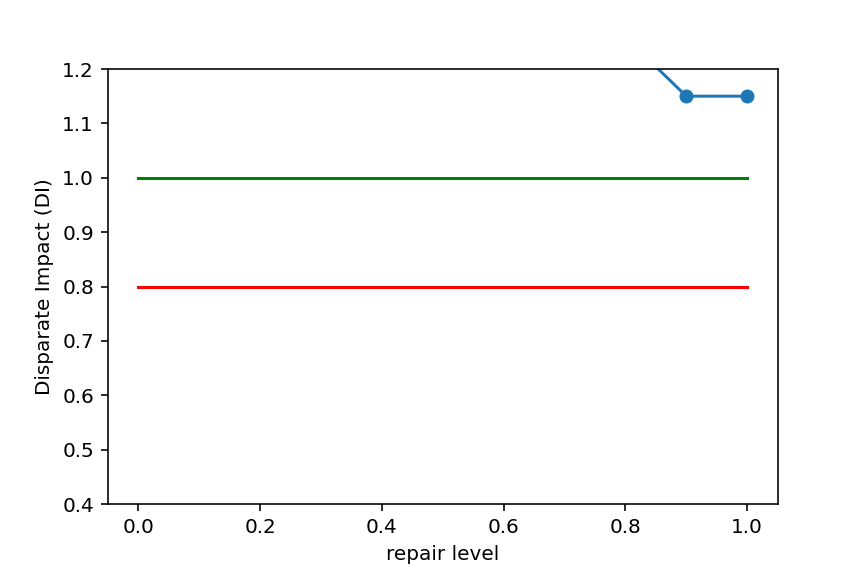

In [17]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

## LIME - Local Interpretable Model-Agnostic Explanations can be used with models learnt with the AIF 360 toolkit to generate explanations for model predictions.

In [18]:
#Train model on given dataset

dataset = dataset_transf_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()        # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
lr_orig = model
lr_scale_orig = scale

In [19]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = lr_scale_orig

model = lr_orig                  #model to test
dataset = dataset_orig_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 530.74it/s]


<IPython.core.display.Javascript object>


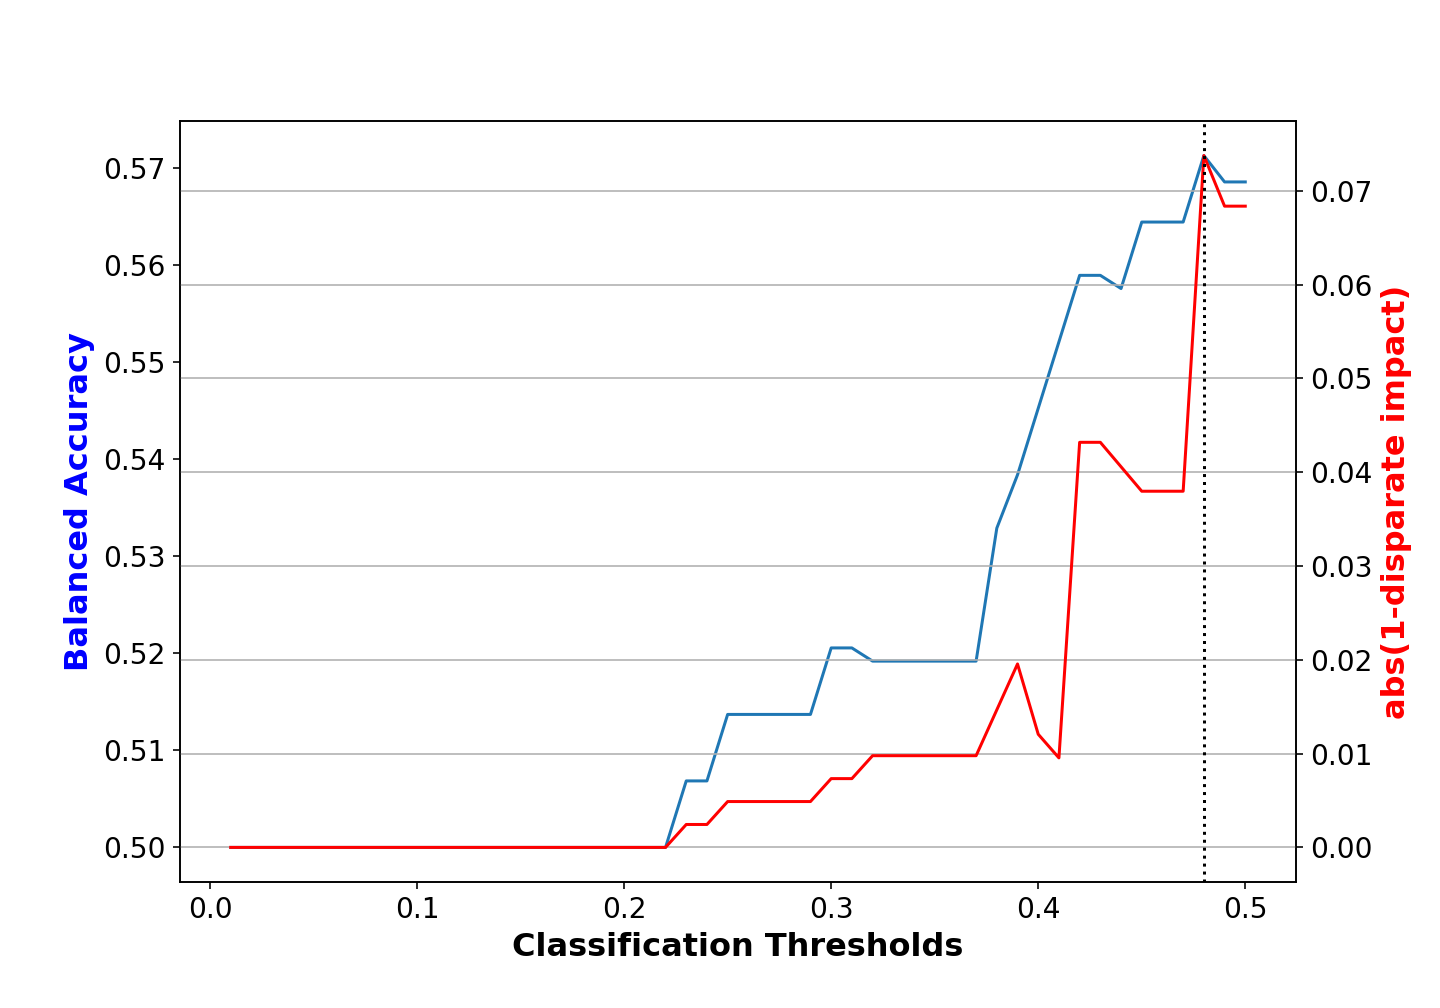

In [20]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

<IPython.core.display.Javascript object>


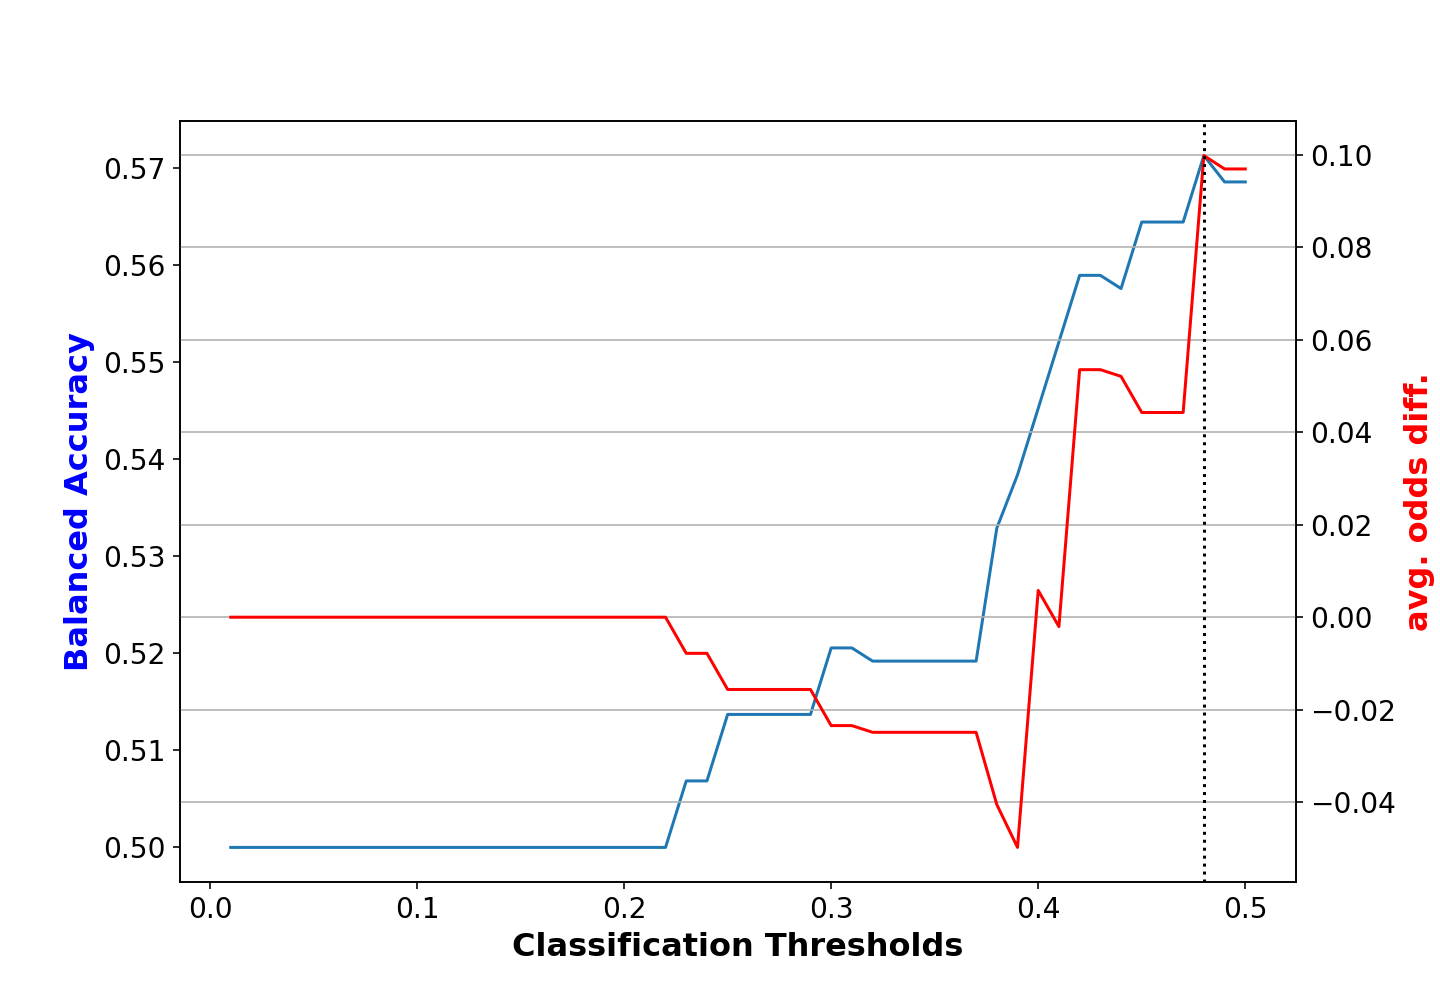

In [21]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [22]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

Threshold corresponding to Best balance accuracy: 0.4800
Best balance accuracy: 0.5713
Corresponding abs(1-disparate impact) value: 0.0738
Corresponding average odds difference value: 0.0998


Threshold corresponding to Best balance accuracy: 0.4800


<IPython.core.display.Javascript object>


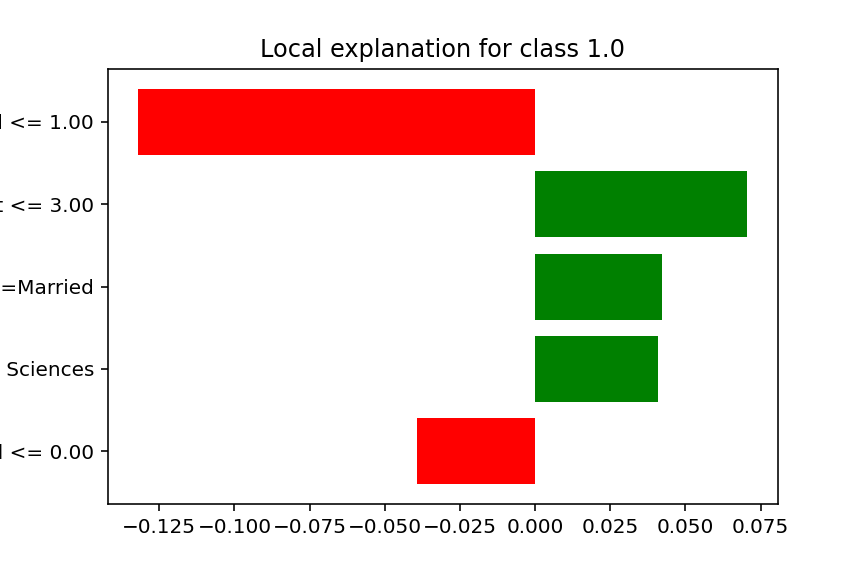

        Actual label: [1.]


<IPython.core.display.Javascript object>


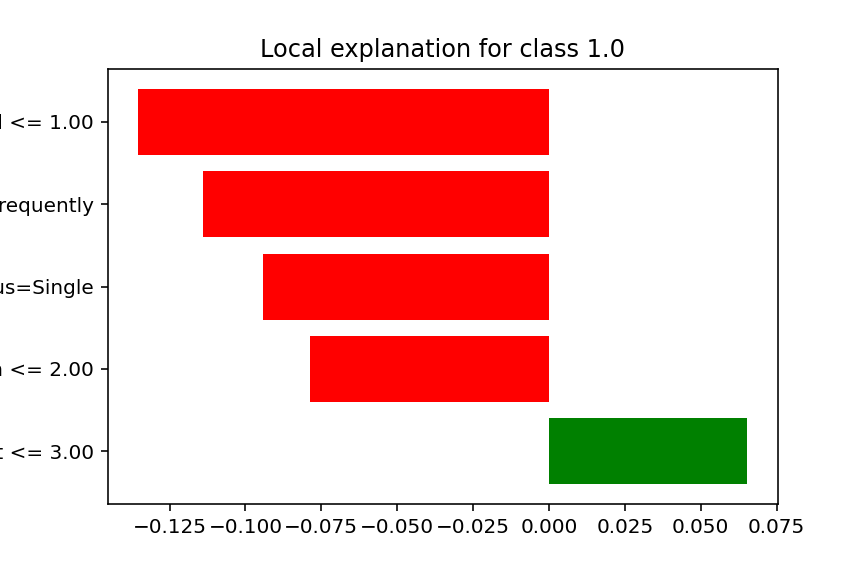

        Actual label: [0.]


In [23]:
limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

scale = lr_scale_orig

model = lr_orig                  #model to test




explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False,discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

import random
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
i1 = 1
exp = explainer.explain_instance(s_test[i1], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i1]))

i2 = 100
exp = explainer.explain_instance(s_test[i2], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i2]))
